Fraud Dataset Missing Values:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Credit Dataset Missing Values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Fraud class distribution (%):
 class
0    90.635423
1     9.364577
Name: proportion, dtype: float64


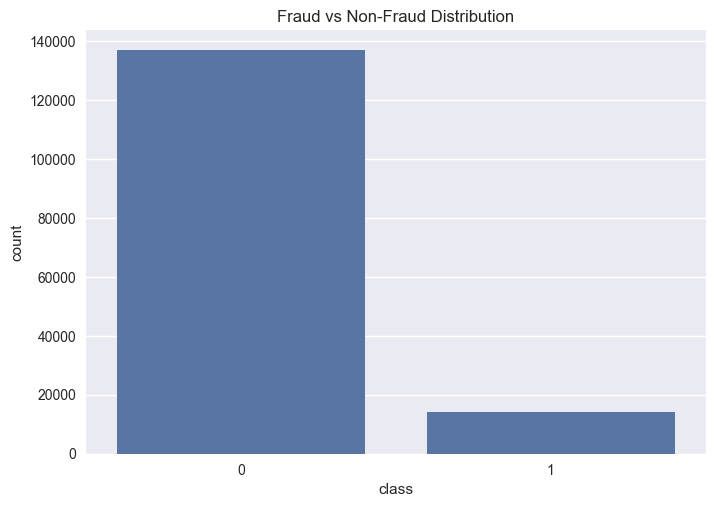

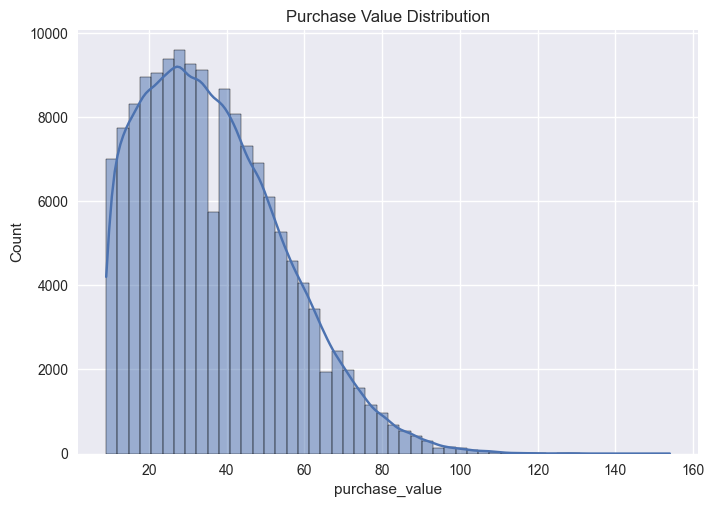

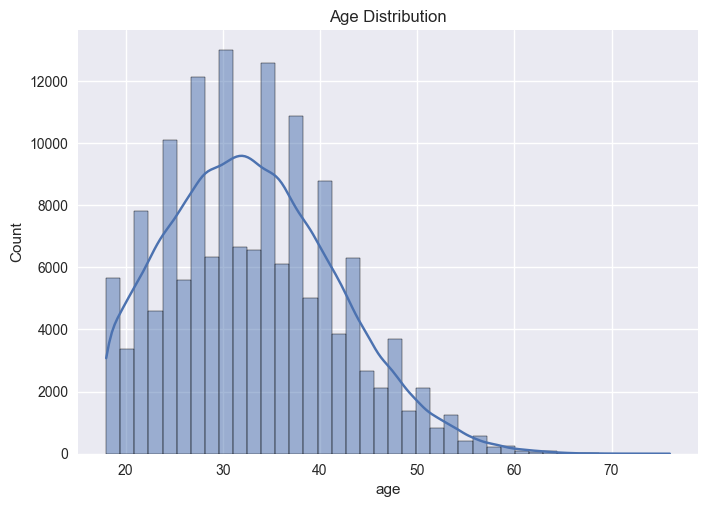

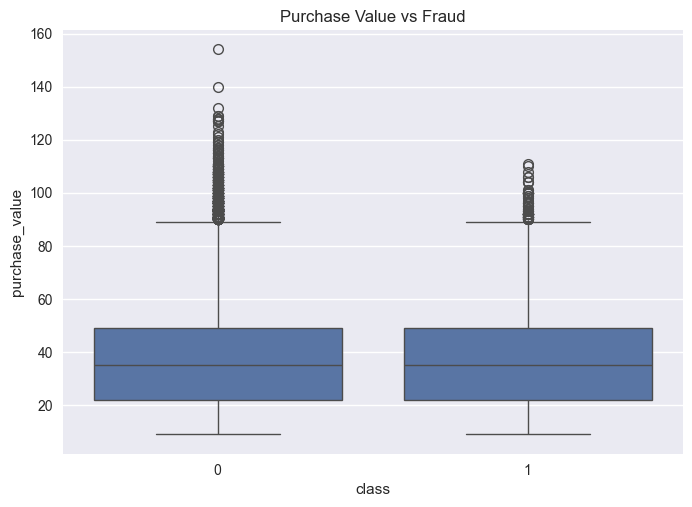

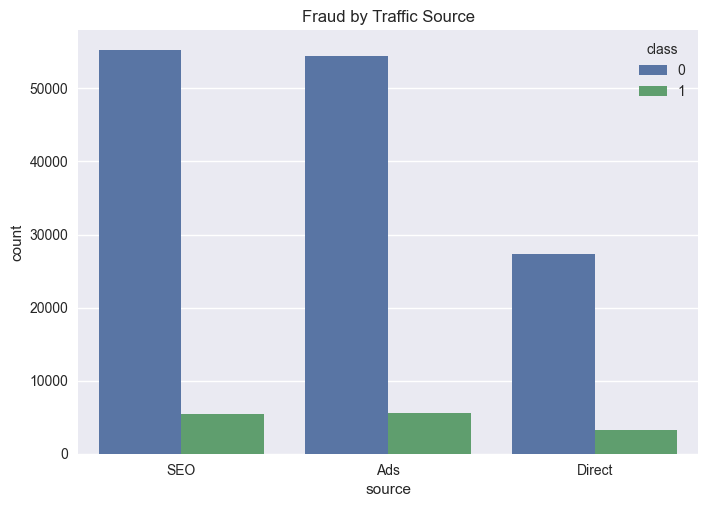

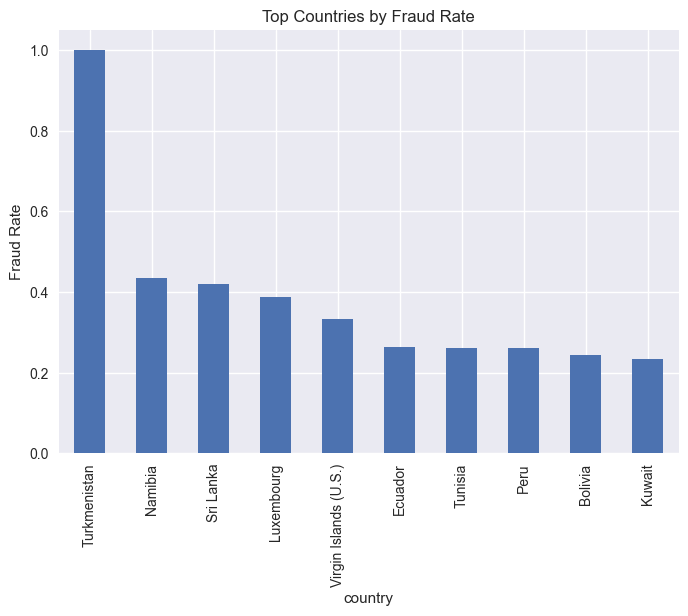

In [23]:
# -----------------------------
# 1️⃣ Data Loading & Cleaning
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_df = pd.read_csv("../data/raw/IpAddress_to_Country.csv")
credit_df = pd.read_csv("../data/raw/creditcard.csv")

# Remove duplicates
fraud_df.drop_duplicates(inplace=True)
credit_df.drop_duplicates(inplace=True)

# Datetime conversion
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# -----------------------------
# 2️⃣ Missing Value Analysis
# -----------------------------
print("Fraud Dataset Missing Values:")
print(fraud_df.isna().sum().sort_values(ascending=False))

print("Credit Dataset Missing Values:")
print(credit_df.isna().sum().sort_values(ascending=False))

# Justification:
# No significant missing values; imputation is not required.

# -----------------------------
# 3️⃣ Exploratory Data Analysis
# -----------------------------

# a) Class Imbalance
fraud_rate = fraud_df['class'].value_counts(normalize=True) * 100
print("Fraud class distribution (%):\n", fraud_rate)

sns.countplot(x='class', data=fraud_df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

# b) Univariate Analysis
sns.histplot(fraud_df['purchase_value'], bins=50, kde=True)
plt.title("Purchase Value Distribution")
plt.show()

sns.histplot(fraud_df['age'], bins=40, kde=True)
plt.title("Age Distribution")
plt.show()

# c) Bivariate Analysis
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title("Purchase Value vs Fraud")
plt.show()

sns.countplot(x='source', hue='class', data=fraud_df)
plt.title("Fraud by Traffic Source")
plt.show()

# -----------------------------
# 4️⃣ Geolocation Integration
# -----------------------------

# Convert IPs to integers
fraud_df['ip_address'] = fraud_df['ip_address'].astype(float).astype(int)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(int)

# Sort for merge_asof
fraud_df = fraud_df.sort_values('ip_address')
ip_df = ip_df.sort_values('lower_bound_ip_address')

# Merge using range-based lookup
fraud_df = pd.merge_asof(
    fraud_df,
    ip_df,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Validate IP range match
fraud_df['country'] = np.where(
    fraud_df['ip_address'] <= fraud_df['upper_bound_ip_address'],
    fraud_df['country'],
    'Unknown'
)
fraud_df['country'] = fraud_df['country'].fillna('Unknown')

# Fraud analysis by country
fraud_by_country = (
    fraud_df.groupby('country')['class']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

fraud_by_country.plot(kind='bar')
plt.title("Top Countries by Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()

# -----------------------------
# 5️⃣ Feature Engineering
# -----------------------------

# a) Time-Based Features
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_since_signup'] = (
    fraud_df['purchase_time'] - fraud_df['signup_time']
).dt.total_seconds()

# b) Transaction Velocity Features
fraud_df['user_tx_count'] = fraud_df.groupby('user_id')['user_id'].transform('count')
fraud_df['device_tx_count'] = fraud_df.groupby('device_id')['device_id'].transform('count')

# c) Handle High Cardinality (Top 10 countries)
top_10_countries = fraud_df['country'].value_counts().nlargest(10).index
fraud_df['country'] = fraud_df['country'].where(
    fraud_df['country'].isin(top_10_countries),
    'Other'
)

# -----------------------------
# 6️⃣ Encoding
# -----------------------------
fraud_df_encoded = pd.get_dummies(
    fraud_df,
    columns=['source', 'browser', 'sex', 'country'],
    drop_first=True
)

# -----------------------------
# 7️⃣ Scaling & SMOTE — JUSTIFICATION
# -----------------------------
# Note: Scaling (StandardScaler) and SMOTE will be applied **during Task 2 on training data only**.
# This prevents data leakage. Here we only describe the plan.




In [24]:
# Drop non-numeric identifiers for modeling
final_cols_to_drop = ['user_id', 'device_id', 'signup_time', 'purchase_time', 
                      'ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address']

fraud_df_final = fraud_df_encoded.drop(columns=[c for c in final_cols_to_drop if c in fraud_df_encoded.columns])

# Save processed Task 1 dataset
fraud_df_final.to_csv("../data/processed/fraud_data_task1_ready.csv", index=False)
